**Paris Airbnb - Prices Prediction - Using XGBoost**

In the following notebook, I use airbnb-data in Paris to try to predict daily price for an airbnb.

**references:**
* Data source: https://public.opendatasoft.com/explore/dataset/airbnb-listings
* https://smarie.github.io/python-odsclient/

In [1]:
pip install odsclient

Note: you may need to restart the kernel to use updated packages.


In [2]:
# -- import libraries -- 
import os
from datetime import date
from collections import Counter
import pickle

# linear algebra
import numpy as np 

# data source
from odsclient import get_whole_dataframe

# data preprocessing
import pandas as pd 
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# model
import xgboost as xgb

In [3]:
# -- Global variables -- 
DATASET_ID = "airbnb-listings"
MODEL_FILE = "xgb_reg.pkl"

**Load the dataset:** 

In [4]:
df = get_whole_dataframe(DATASET_ID, platform_id='public')

# -- Taking only Paris for predictions --  
paris_airbnb_ = df.loc[df['City'] == 'Paris']

/opt/conda/lib/python3.7/site-packages/odsclient/core.py:549: UserWarning: `keyring` is not installed but the `ODSClient` is configured to use it. You can eitherset `use_keyring=False` explicitly or install keyring to disable this warning. Caught: ModuleNotFoundError("No module named 'keyring'")
  "Caught: %r" % e)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3427: DtypeWarning: Columns (0,2,66) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


loading the dataset, using the command above, takes more then an hour, so to save that time, I saved the data as csv file, in this way it takes only few minutes to load the data:

In [5]:
paris_airbnb_.to_csv("paris_airbnb", index=False)

In [6]:
paris_airbnb = pd.read_csv("paris_airbnb") 

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (40,82) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
print("shape of the dataset: ", paris_airbnb.shape)
paris_airbnb.head(1)

shape of the dataset:  (54513, 89)


,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,...,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,7735531,https://www.airbnb.com/rooms/7735531,20170404145355,2017-04-06,Petit cocon au coeur de Paris,"Bienvenue chez moi, j'habite en plein centre d...","Idéalement situé a 2 pas du métro, de Beaubour...","Bienvenue chez moi, j'habite en plein centre d...",none,"Mon quartier ""Le Marais"" est unique à Paris. A...",...,10.0,10.0,10.0,NaN,Paris,moderate,1.0,0.98,"48.8586544864,2.35346198925","Host Has Profile Pic,Is Location Exact"


**check the data:**

* check that we don't have duplicated rows in the dataset:

In [8]:
print("duplicated rows: ", paris_airbnb.duplicated().sum())

duplicated rows:  0


* getting info on the columns: (types, 'not null' count)

In [9]:
paris_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54513 entries, 0 to 54512
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              54513 non-null  int64  
 1   Listing Url                     54513 non-null  object 
 2   Scrape ID                       54513 non-null  int64  
 3   Last Scraped                    54513 non-null  object 
 4   Name                            54510 non-null  object 
 5   Summary                         52368 non-null  object 
 6   Space                           37975 non-null  object 
 7   Description                     54506 non-null  object 
 8   Experiences Offered             54513 non-null  object 
 9   Neighborhood Overview           32669 non-null  object 
 10  Notes                           17480 non-null  object 
 11  Transit                         35008 non-null  object 
 12  Access                          

**Preprocessing:**

1.  removing unnecessary features:
    * **'Country','City', 'State', 'Jurisdiction Names', 'Host Location', 'Market', 'Zipcode','Country Code', 'Smart Location'**: since we are going to predict prices only for paris, we can take them off.
    * prices: since most of the airbnb don't have a special price for a whole week or month, we will drop **'Weekly Price'** and **'Monthly Price'** columns, and predict only daily price. (but I'll do that after filling null values in price column) 
    * **'Name', 'ID', 'Host Name', 'Host ID', 'Calendar Updated', 'Listing Url', 'Picture Url', 'Neighbourhood Cleansed', 'Interaction', 'Host Thumbnail Url', 'Thumbnail Url', 'Medium Url', 'XL Picture Url','Host Picture Url', 'Host URL'**: columns that will not help us in prediction 
    * empty columns: **'Host Acceptance Rate', 'Neighbourhood Group Cleansed', 'Experiences Offered', 'Experiences Offered', 'Has Availability', 'License'**
    * **'Host About'**: since I don't want to be racist in my solution I decided to delete this column, (some hosts wrote their gender, race, age ..) 
    * more columns that I'll not use for now (free-text columns): **'Access', 'Notes', 'Neighborhood Overview', 'House Rules', 'Description', 'Space', 'Summary'** 
    * **'Square Feet'**: this column is almost completly empty

In [10]:
columns_to_drop = ['Country','City', 'State', 'Host Location', 'Name', 'Host Name', 'Market', 'Zipcode', 
                   'Host About', 'Host Acceptance Rate', 'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed', 
                   'Calendar Updated', 'Picture Url', 'Listing Url', 'Jurisdiction Names','Experiences Offered', 
                   'Interaction', 'Experiences Offered', 'Has Availability','License','Host Thumbnail Url', 
                   'Thumbnail Url', 'Medium Url', 'XL Picture Url','Host Picture Url', 'Access', 'Notes', 
                   'Neighborhood Overview', 'House Rules', 'Description', 'Space','Summary','Square Feet', 
                   'Host URL', 'Country Code','Host ID', 'Smart Location', 'ID', 'Scrape ID']

paris_airbnb = paris_airbnb.drop(columns=columns_to_drop, axis=1)
print('dataset shape after dropping irrelevant columns: ', paris_airbnb.shape)

dataset shape after dropping irrelevant columns:  (54513, 50)


2. filling empty cells:

In [11]:
# checking how many empty cells there are in each column
nullseries = paris_airbnb.isnull().sum()
print(nullseries[nullseries > 0])

Transit                        19505
Host Since                        11
Host Response Time             18096
Host Response Rate             18096
Host Neighbourhood              6479
Host Listings Count               11
Host Total Listings Count         11
Host Verifications                50
Neighbourhood                   7523
Bathrooms                        184
Bedrooms                         134
Beds                              75
Amenities                        406
Price                             54
Weekly Price                   38430
Monthly Price                  42345
Security Deposit               24406
Cleaning Fee                   19919
First Review                   13465
Last Review                    13463
Review Scores Rating           14250
Review Scores Accuracy         14355
Review Scores Cleanliness      14330
Review Scores Checkin          14378
Review Scores Communication    14335
Review Scores Location         14368
Review Scores Value            14375
R

let's analyze the missing data:
* **'price'** - there are ~50 rows without daily prices, we will try to get the price per day from columns 'Weekly Price', 'Monthly Price', but if they are also empty - I will have to delete this row.

In [12]:
null_rows = paris_airbnb[paris_airbnb["Price"].isnull()].index

paris_airbnb.fillna({'Weekly Price':-1}, inplace=True)
paris_airbnb.fillna({'Monthly Price':-1}, inplace=True)

for idx in null_rows:
    weekly_price = paris_airbnb.loc[idx,"Weekly Price"]
    monthly_price = paris_airbnb.loc[idx,"Monthly Price"]
    
    if not (weekly_price == -1):
        paris_airbnb.loc[idx,"Price"] = weekly_price / 7
        
    elif not (monthly_price == -1):
        paris_airbnb.loc[idx,"Price"] = monthly_price / 30

# columns "Weekly Price", "Monthly Price" - are not needed anymore:
paris_airbnb = paris_airbnb.drop(columns=["Weekly Price", "Monthly Price"], axis=1)
        
# let's see if there are empty cells left:
print('\nremaining null prices: ', paris_airbnb["Price"].isnull().sum())


remaining null prices:  43


There are still 43 rows without prices, so I will delete those rows from the database:

In [13]:
paris_airbnb = paris_airbnb.dropna(subset=["Price"])
paris_airbnb["Price"].isnull().sum()

0

In [14]:
paris_airbnb["Price"].describe()

count    54470.000000
mean        94.864074
std         73.877700
min          0.000000
25%         55.000000
50%         75.000000
75%        107.000000
max       1666.666667
Name: Price, dtype: float64

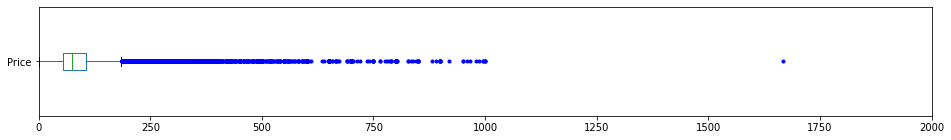

In [15]:
price_boxplot = dict(markerfacecolor='b', markeredgecolor='b', marker='.')
paris_airbnb['Price'].plot(kind='box', xlim=(0, 2000), vert=False, flierprops=price_boxplot, figsize=(16,2));

we can see clearly that there is one airbnb that is not in the standard prices, since it's only one airbnb, I guess it's a typo, so I'll delete this row:

In [16]:
# removing zeros and outliers:
paris_airbnb.drop(paris_airbnb[(paris_airbnb['Price'] == 0) | (paris_airbnb['Price'] > 1000)].index, axis=0, inplace=True)

* **'Reviews per Month', 'Cleaning Fee', 'Security Deposit'** - if not mentioned it's a zero. 

In [17]:
paris_airbnb.fillna({'Reviews per Month':0}, inplace=True)
paris_airbnb.fillna({'Cleaning Fee': 0.0}, inplace=True)
paris_airbnb.fillna({'Security Deposit': 0.0}, inplace=True)

* columns: **'Review Scores Rating','Review Scores Accuracy','Review Scores Cleanliness','Review Scores Checkin',  
'Review Scores Communication','Review Scores Location', 'Review Scores Value', 'Host Response Rate'**, I'll fill them with the mean value of each column, to give them the benefit of the doubt. cause maybe their clients never rated them from laziness or they are newbies.




In [18]:
paris_airbnb.fillna({'Review Scores Rating': paris_airbnb['Review Scores Rating'].mean()}, inplace=True)
paris_airbnb.fillna({'Review Scores Accuracy': paris_airbnb['Review Scores Accuracy'].mean()}, inplace=True)
paris_airbnb.fillna({'Review Scores Cleanliness': paris_airbnb['Review Scores Cleanliness'].mean()}, inplace=True)
paris_airbnb.fillna({'Review Scores Checkin': paris_airbnb['Review Scores Checkin'].mean()}, inplace=True)
paris_airbnb.fillna({'Review Scores Communication': paris_airbnb['Review Scores Communication'].mean()}, inplace=True)
paris_airbnb.fillna({'Review Scores Location': paris_airbnb['Review Scores Location'].mean()}, inplace=True)
paris_airbnb.fillna({'Review Scores Value': paris_airbnb['Review Scores Value'].mean()}, inplace=True)
paris_airbnb.fillna({'Host Response Rate': paris_airbnb['Host Response Rate'].mean()}, inplace=True)

* **'Host Response Time'**: fill with new category: 'Not mentioned'

In [19]:
paris_airbnb.fillna({'Host Response Time': 'Not mentioned'}, inplace=True)

* dates-type columns: 
    * **'Host Since'**: fill with today's date 
    * **'First Review', 'Last Review'**: fill with the date '0001/01/01' and it will represent 'never rated'. 

In [20]:
today = date.today()

paris_airbnb.fillna({'Host Since': today}, inplace=True)

#min_date = date.min
paris_airbnb.fillna({'First Review': 0}, inplace=True)
paris_airbnb.fillna({'Last Review': 0}, inplace=True)

* **'Host Listings Count', 'Host Total Listings Count'**: for empty cells the assumption is that they have only one airbnb (the current one).

In [21]:
paris_airbnb.fillna({'Host Listings Count': 1}, inplace=True)
paris_airbnb.fillna({'Host Total Listings Count': 1}, inplace=True)

* **'Bathrooms', 'Bedrooms', 'Beds'**: will try to get information about the missing values from the column **'Property Type'**

In [22]:
# -- Bathrooms --
# property types in the missing bathrooms rows
tmp = paris_airbnb[paris_airbnb['Bathrooms'].isnull()]
print(tmp['Property Type'].unique())

['Apartment' 'Bed & Breakfast' 'Loft' 'House']


In [23]:
#filling empty cells with the mean value of for each property type:

null_idxs = paris_airbnb[paris_airbnb['Bathrooms'].isnull()].index

for idx in null_idxs:
    property_type = paris_airbnb.loc[idx, 'Property Type']
                     
    if property_type == 'Loft' :
        mean_bathrooms = round(paris_airbnb.Bathrooms[paris_airbnb['Property Type'] == 'Loft'].mean())
        paris_airbnb.loc[idx, 'Bathrooms'] = mean_bathrooms
    
    if property_type == 'Bed & Breakfast':
        mean_bathrooms = round(paris_airbnb.Bathrooms[paris_airbnb['Property Type'] == 'Bed & Breakfast'].mean())
        paris_airbnb.loc[idx, 'Bathrooms'] = mean_bathrooms
    
    if property_type == 'House':
        mean_bathrooms = round(paris_airbnb.Bathrooms[paris_airbnb['Property Type'] == 'House'].mean())
        paris_airbnb.loc[idx, 'Bathrooms'] = mean_bathrooms
        
    if property_type == 'Apartment':
        mean_bathrooms = round(paris_airbnb.Bathrooms[paris_airbnb['Property Type'] == 'Apartment'].mean())
        paris_airbnb.loc[idx, 'Bathrooms'] = mean_bathrooms   
        
#check again:
paris_airbnb['Bathrooms'].isnull().sum()

0

In [24]:
# -- Beds -- 
tmp = paris_airbnb[paris_airbnb['Beds'].isnull()]
print(tmp['Property Type'].unique())

['Apartment' 'House' 'Bed & Breakfast' 'Loft']


In [25]:
null_idxs = paris_airbnb[paris_airbnb['Beds'].isnull()].index

for idx in null_idxs:
    property_type = paris_airbnb.loc[idx, 'Property Type']
                     
    if property_type == 'Bed & Breakfast':
        mean_beds = round(paris_airbnb.Beds[paris_airbnb['Property Type'] == 'Bed & Breakfast'].mean())
        paris_airbnb.loc[idx, 'Beds'] = mean_beds
    
    if property_type == 'Loft' :
        mean_beds = round(paris_airbnb.Beds[paris_airbnb['Property Type'] == 'Loft'].mean())
        paris_airbnb.loc[idx, 'Beds'] = mean_beds
        
    if property_type == 'Apartment':
        mean_beds = round(paris_airbnb.Beds[paris_airbnb['Property Type'] == 'Apartment'].mean())
        paris_airbnb.loc[idx, 'Beds'] = mean_beds  
    
    if property_type == 'House':
        mean_beds = round(paris_airbnb.Beds[paris_airbnb['Property Type'] == 'House'].mean())
        paris_airbnb.loc[idx, 'Beds'] = mean_beds
        
#check again:
paris_airbnb['Beds'].isnull().sum()

0

In [26]:
# -- Bedrooms -- 
new = paris_airbnb[paris_airbnb['Bedrooms'].isnull()]
print(new['Property Type'].unique())

['Apartment' 'House' 'Loft' 'Condominium']


In [27]:
null_idxs = paris_airbnb[paris_airbnb['Bedrooms'].isnull()].index

for idx in null_idxs:
    property_type = paris_airbnb.loc[idx, 'Property Type']
                     
    if property_type == 'Loft' :
        mean_bedrooms = round(paris_airbnb.Bedrooms[paris_airbnb['Property Type'] == 'Loft'].mean())
        paris_airbnb.loc[idx, 'Bedrooms'] = mean_bedrooms
        
    if property_type == 'Apartment':
        mean_bedrooms = round(paris_airbnb.Bedrooms[paris_airbnb['Property Type'] == 'Apartment'].mean())
        paris_airbnb.loc[idx, 'Bedrooms'] = mean_bedrooms
    
    if property_type == 'Condominium':
        mean_bedrooms = round(paris_airbnb.Bedrooms[paris_airbnb['Property Type'] == 'Condominium'].mean())
        paris_airbnb.loc[idx, 'Bedrooms'] = mean_bedrooms  
    
    if property_type == 'House':
        mean_bedrooms = round(paris_airbnb.Bedrooms[paris_airbnb['Property Type'] == 'House'].mean())
        paris_airbnb.loc[idx, 'Bedrooms'] = mean_bedrooms
        
#check again:
paris_airbnb['Bedrooms'].isnull().sum()

0

In [28]:
#check that everything has been taken care of:
nullseries = paris_airbnb.isnull().sum()
print(nullseries[nullseries > 0])

Transit               19484
Host Neighbourhood     6477
Host Verifications       50
Neighbourhood          7514
Amenities               406
Features                 18
dtype: int64


* **Features, Amenities, Host Verifications,Transit** - will take care in feature engineering.
* **Host Neighbourhood, Neighbourhood** - (3,4)

🙃🙃🙃


3. label categorical variables with an implied order:

    it means that in this categorical features the order is important for predicting the price, for example 'Bed Type': Real Bed is much better then a couch. 

    columns to convert into integers: **'Host Response Time', 'Bed Type', 'Cancellation Policy', 'Property Type', 'Room Type', 'Neighbourhood', 'Street'**

In [29]:
categorical_columns = ['Host Response Time', 'Bed Type', 'Cancellation Policy', 'Property Type', 'Room Type',
                       'Neighbourhood', 'Street']

for col in categorical_columns:
    items = paris_airbnb[col].unique()
    for i in range(len(items)):
        paris_airbnb[col] = paris_airbnb[col].replace(items[i], i)

4. **'Host Neighbourhood'**: label the same or not the same (1 or 0) as the Airbnb neighbourhood.
also fill empty cells with 0.

In [30]:
paris_airbnb.loc[paris_airbnb['Host Neighbourhood'] == paris_airbnb['Neighbourhood'], 'Host Neighbourhood'] = 1
paris_airbnb.loc[paris_airbnb['Host Neighbourhood'] != 1, 'Host Neighbourhood'] = 0

paris_airbnb["Host Neighbourhood"] = paris_airbnb["Host Neighbourhood"].astype('int')

paris_airbnb.rename(columns = {'Host Neighbourhood': 'Airbnb_in_host_neighbourhood'}, inplace = True)

5. dates columns: **'Host Since','Calendar last Scraped','Last Scraped','First Review','Last Review'**- convert into datetime.

In [31]:
paris_airbnb['Host Since'] = pd.to_datetime(paris_airbnb['Host Since']).astype(int)
paris_airbnb['First Review'] = pd.to_datetime(paris_airbnb['First Review']).astype(int)
paris_airbnb['Last Review'] = pd.to_datetime(paris_airbnb['Last Review']).astype(int)
paris_airbnb['Calendar last Scraped'] = pd.to_datetime(paris_airbnb['Calendar last Scraped']).astype(int)
paris_airbnb['Last Scraped'] = pd.to_datetime(paris_airbnb['Last Scraped']).astype(int)

**Feature Engineering:**

1. First let's take a look at the column **Amenities**:

    Each airbnb has different amenities and we want to be able to give this information to the model by encoding this column into new columns for each amenity, with the value 1 or 0, that represent whether or not this amenity provided in this airbnb.
Then delete the column 'Amenities' since it's not needed anymore.

In [32]:
# print all amenities:
paris_airbnb['Amenities'].head()

0    Wireless Internet,Kitchen,Elevator in building...
1    TV,Internet,Wireless Internet,Kitchen,Heating,...
2    TV,Cable TV,Internet,Wireless Internet,Kitchen...
3    TV,Cable TV,Internet,Wireless Internet,Kitchen...
4    TV,Cable TV,Internet,Wireless Internet,Kitchen...
Name: Amenities, dtype: object

In [33]:
# make a dictionary from the amenities
amenities_counter = Counter()

# delete {},"",/,\, and split them by comma
paris_airbnb['Amenities'].astype('str').str.strip('{}')\
                                       .str.replace('"', '')\
                                       .str.lstrip('\"')\
                                       .str.rstrip('\"')\
                                       .str.split(',')\
                                       .apply(amenities_counter.update)

# check how many amenities we have in total
print(len(amenities_counter))

# print the most common items
amenities_counter.most_common(10)

70


[('Kitchen', 52028),
 ('Heating', 51668),
 ('Wireless Internet', 51213),
 ('Essentials', 46556),
 ('Washer', 41864),
 ('Internet', 36301),
 ('TV', 36139),
 ('Smoke detector', 32413),
 ('Family/kid friendly', 30208),
 ('Iron', 28819)]

In [34]:
# for the purpose of the project I'll take only the most 30 common amenities
for item,_ in amenities_counter.most_common(30):
    col_name = 'amenity_' + item.replace(" ", "_")
    paris_airbnb[col_name] = paris_airbnb['Amenities'].astype('str').apply(lambda x: int(item in x))

paris_airbnb.head(1) 

,Last Scraped,Transit,Host Since,Host Response Time,Host Response Rate,Airbnb_in_host_neighbourhood,Host Listings Count,Host Total Listings Count,Host Verifications,Street,...,amenity_Smoking_allowed,amenity_translation_missing:_en.hosting_amenity_49,amenity_Carbon_monoxide_detector,amenity_Safety_card,amenity_First_aid_kit,amenity_Breakfast,amenity_Fire_extinguisher,amenity_Pets_allowed,amenity_Indoor_fireplace,amenity_Wheelchair_accessible
0,1491436800000000000,Mon appartement est à seulement quelques mètre...,1433980800000000000,0,100.0,0,1.0,1.0,"email,phone,reviews",0,...,0,1,0,0,0,0,0,0,0,0


In [35]:
# delete 'Amenities' column
paris_airbnb.drop(columns=['Amenities'], axis=1, inplace=True)

2. **Host Verifications** (Using the same concept as Amenities)

In [36]:
paris_airbnb['Host Verifications'].head()

0                   email,phone,reviews
1             email,phone,reviews,jumio
2             email,phone,reviews,jumio
3    email,phone,facebook,reviews,jumio
4                   email,phone,reviews
Name: Host Verifications, dtype: object

In [37]:
# make a dictionary from the 'Host Verifications'
verifications_counter = Counter()

# delete {},"",/,\
paris_airbnb['Host Verifications'].astype('str').str.strip('{}')\
                                       .str.replace('"', '')\
                                       .str.lstrip('\"')\
                                       .str.rstrip('\"')\
                                       .str.split(',')\
                                       .apply(verifications_counter.update)

# check how many verifications we have in total
print(len(verifications_counter))

# print the most common items
verifications_counter.most_common(10)

23


[('phone', 53708),
 ('email', 52569),
 ('reviews', 48024),
 ('jumio', 30502),
 ('facebook', 9876),
 ('government_id', 8726),
 ('work_email', 3254),
 ('offline_government_id', 2172),
 ('manual_offline', 1896),
 ('google', 1774)]

In [38]:
# I'll take only the most 10 common verifications
for item,_ in verifications_counter.most_common(10):
    col_name = 'host_verification' + item.replace(" ", "_")
    paris_airbnb[col_name] = paris_airbnb['Host Verifications'].astype('str').apply(lambda x: int(item in x))

# delete 'Host Verifications' column
paris_airbnb.drop(columns=['Host Verifications'], axis=1, inplace=True)

print(paris_airbnb.shape)

(54468, 86)


3. **Features**  (Using the same concept as Amenities)

In [39]:
paris_airbnb['Features'].head()

0               Host Has Profile Pic,Is Location Exact
1    Host Has Profile Pic,Host Identity Verified,Is...
2    Host Has Profile Pic,Host Identity Verified,Is...
3    Host Has Profile Pic,Host Identity Verified,Is...
4               Host Has Profile Pic,Is Location Exact
Name: Features, dtype: object

In [40]:
# make a dictionary from the 'Features'
features_counter = Counter()

# delete {},"",/,\
paris_airbnb['Features'].astype('str').str.strip('{}')\
                                       .str.replace('"', '')\
                                       .str.lstrip('\"')\
                                       .str.rstrip('\"')\
                                       .str.split(',')\
                                       .apply(features_counter.update)

# check how many features we have in total
print(len(features_counter))

# print the most common features
features_counter.most_common(5)

8


[('Host Has Profile Pic', 54255),
 ('Is Location Exact', 46539),
 ('Host Identity Verified', 29949),
 ('Instant Bookable', 11572),
 ('Host Is Superhost', 3089)]

In [41]:
# I'll take only the most 5 common verifications
for item,_ in features_counter.most_common(5):
    col_name = item.replace(" ", "_")
    paris_airbnb[col_name] = paris_airbnb['Features'].astype('str').apply(lambda x: int(item in x))

# delete 'Features' column
paris_airbnb.drop(columns=['Features'], axis=1, inplace=True)

print(paris_airbnb.shape)

(54468, 90)


4. **Transit**: this is a free-text column, i'll create 3 new columns (bus, train, metro) and fill them according to column 'transit'.

In [42]:
paris_airbnb.fillna({'Transit': ''}, inplace=True)

paris_airbnb['Transit_Bus'] = paris_airbnb['Transit'].str.contains('Bus').astype('int')
paris_airbnb['Transit_Metro'] = paris_airbnb['Transit'].str.contains('|'.join(['Metro','Métro'])).astype('int')
paris_airbnb['Transit_Train'] = paris_airbnb['Transit'].str.contains('|'.join(['Train','Ligne'])).astype('int')

paris_airbnb.drop(columns=['Transit'], axis=1, inplace=True)

5. **'Geolocation'**: using this column we can extract 2 new columns: 'latitude' and 'longitude'

In [43]:
# (After writing that, I realized that there are already columns of latitude and longitude in this 
# dataset, have no idea why they needed another column for 'geolocation')

#latitude_N_longitude = paris_airbnb['Geolocation'].astype('str').str.split(',', expand=True).astype('float64')
#latitude_N_longitude.rename(columns={0: 'latitude', 1: 'longitude'}, inplace=True)
#paris_airbnb = pd.concat([paris_airbnb, latitude_N_longitude],axis = 1)

paris_airbnb = paris_airbnb.drop(columns=['Geolocation'], axis=1)

**let's plot the airbnb-prices according to the longitude and latitude:**

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


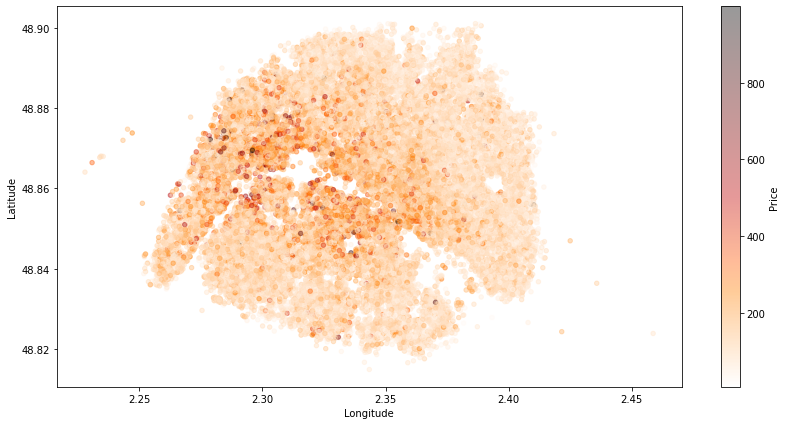

In [44]:
paris_airbnb.plot(kind="scatter", 
                  x="Longitude", y="Latitude", 
                  alpha=0.4, figsize=(14,7), 
                  c="Price", cmap="gist_heat_r", 
                  colorbar=True, sharex=False);

**We can see that the closer the airbnb is to the city center, the higher the price.**

In [45]:
#make sure all the columns left are really useful:
paris_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54468 entries, 0 to 54512
Data columns (total 91 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Last Scraped                                        54468 non-null  int64  
 1   Host Since                                          54468 non-null  int64  
 2   Host Response Time                                  54468 non-null  int64  
 3   Host Response Rate                                  54468 non-null  float64
 4   Airbnb_in_host_neighbourhood                        54468 non-null  int64  
 5   Host Listings Count                                 54468 non-null  float64
 6   Host Total Listings Count                           54468 non-null  float64
 7   Street                                              54468 non-null  int64  
 8   Neighbourhood                                       54468 non-null  int64  


**Train, Test Split**

In [46]:
y = paris_airbnb.loc[:,'Price']
X = paris_airbnb.drop(columns=['Price'], axis=1)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                                                                    test_size=0.25, 
                                                                    random_state=42)

**Model**

* one of the most popular ML-algorithem is **XGB** (Extreme Gradient Boosting), that based on the 'wisdom of the crowd' methodology, where collective opinion of a group of individuals is better then a single expert.
'XGB' is using a grup of weak-learners (stamp-trees), to give predictions that more accurate then a single strong-learner algorithem.

* also I'll use **grid search** that will find the best parameters to use in XGB with this specific data.

* and **cross validation** to test the model's ability to predict new data that was not used in estimating. 

In [48]:
# -- Grid search -- 
xgb_model = xgb.XGBRegressor()

grid_param = {'n_estimators': [50, 100, 200],
              'learning_rate': [1e-01, 5e-02, 1e-03], 
              'max_depth': [3, 5, 7],
              'colsample_bytree': [0.5, 0.7, 1],
              'gamma': [0.0, 0.2, 1, 10]}   # how much conservative the algoritem will be 

xgb_grid_search = model_selection.GridSearchCV(xgb_model, 
                                               grid_param, 
                                               cv=2,   # k-fold parameter for cross-validation 
                                               n_jobs=-1 # number of jobs in parallel, -1 means using all processors
                                               )

xgb_grid_search.fit(X_train, y_train)

# -- Print the best parameters that found -- 
best_param = xgb_grid_search.best_params_
#print(best_param)

In [49]:
# -- instantiate xgboost with best parameters --
booster = xgb.XGBRegressor(colsample_bytree=0.5, 
                           gamma=0.2,
                           learning_rate=0.05,
                           max_depth=5,
                           n_estimators=200,
                           random_state=42, 
                           alpha=10)

# -- Train --
evalset = [(X_train, y_train), (X_test,y_test)]
result = booster.fit(X_train, y_train,eval_metric=['rmse'] ,eval_set=evalset, verbose=0)

results = booster.evals_result()

learning curves:

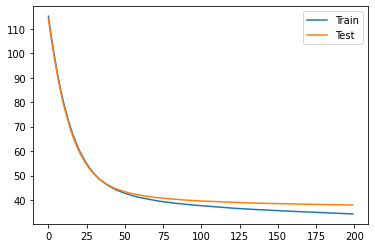

In [50]:
# -- plot learning curves --
plt.plot(results['validation_0']['rmse'], label='Train')
plt.plot(results['validation_1']['rmse'], label='Test')
plt.legend()
plt.show()

plot feature importance based on fitted model:

(this way we can see which features was matter the most in the model, by counting the number of times each feature is split across all trees in the model. it helps in feature selection and more)

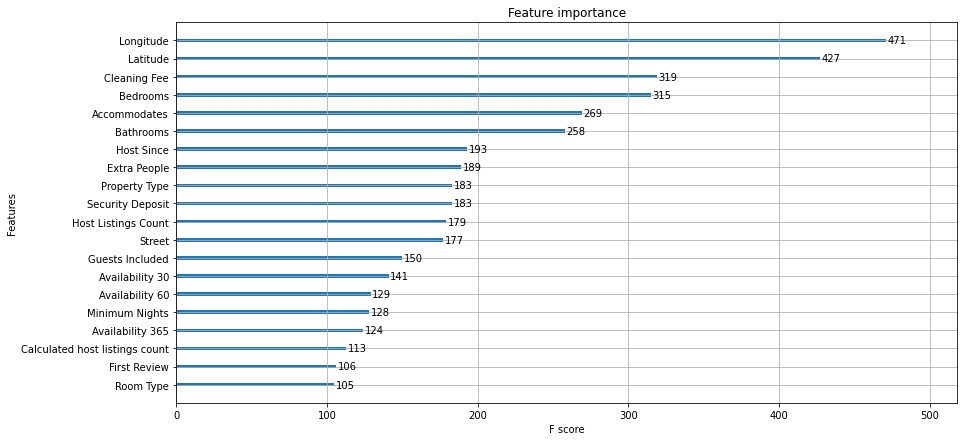

In [51]:
_, ax = plt.subplots(1,1,figsize=(14, 7))
xgb.plot_importance(booster=booster, ax=ax, max_num_features=20)
plt.show()

We can see that the features Longitude and Latitude has been given the highest importance score among all the features. (based upon this importance score, we can select the features with highest importance score and discard the redundant ones)

In [52]:
# -- cross validation -- 
best_param = {'objective': 'reg:squarederror',  #regression with squared loss
              'colsample_bytree': 0.5,
              'learning_rate': 0.05,
              'max_depth': 5, 
              'gamma':0.2}


xg_train = xgb.DMatrix(data=X_train, label=y_train) # help to speed up the procces and to save memory space

cv_results = xgb.cv(dtrain=xg_train, 
                    params=best_param, 
                    nfold=5,
                    num_boost_round=200, 
                    early_stopping_rounds=10, 
                    metrics="rmse",  # root mean square error (for regression)
                    as_pandas=True) 

cv_results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
195,33.702479,0.319029,39.985699,1.337657
196,33.680013,0.320673,39.977276,1.333617
197,33.656221,0.320729,39.967860,1.336553
198,33.630306,0.325101,39.963303,1.337073
199,33.602141,0.327430,39.952441,1.334676


In [53]:
# -- save model --
pickle.dump(booster, open(MODEL_FILE, "wb"))

In [54]:
# -- load model --
xgb_model = pickle.load(open(MODEL_FILE, "rb"))